In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io
import anndata

from tools import kobak_tsne_w_exag, pickle_sanity_results

### Load preproc

In [2]:
with open('datasets/cao/gene_count.txtpreprocessed.pickle','rb') as f:
    data_dict = pickle.load(f)

var = pd.DataFrame(dict(genes=data_dict['genes']))
obs = pd.DataFrame(dict(cells=data_dict['cells'],
                       embryo=data_dict['embryo']))

adata = anndata.AnnData(X=data_dict['counts'], var=var, obs=obs)

adata.var_names_make_unique()

/tmp/ipykernel_2008/646953741.py:2: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  data_dict = pickle.load(f)
tcmalloc: large alloc 10011041792 bytes == 0x5a16000 @ 
tcmalloc: large alloc 5005524992 bytes == 0x25ae5e000 @ 
/tmp/ipykernel_2008/646953741.py:8: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X=data_dict['counts'], var=var, obs=obs)
tcmalloc: large alloc 5005524992 bytes == 0x38e038000 @ 
tcmalloc: large alloc 5005524992 bytes == 0x4b85dc000 @ 
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
# read in cluster labels
clusters = data_dict['cluster'].copy()
clusters[~np.isnan(clusters)] -= 1
clusters[np.isnan(clusters)] = -1
clusters = clusters.astype(int)

# cluster names - "Main cluster" and "Main cell type" contain the same info
cluster_names = data_dict['cluster_names'][np.unique(clusters, return_index=True)[1][1:]].copy()

#set up colors
clusterColors = np.array('''#c886ba #5cbb5e #9751a0 #84b941 #8e6db0 #bbbb3c #5667b0 #e58824 #778cc6 #d6ac3d
#785aa5 #204a87 #36384a #5ec08d #e53e77 #50c1b4 #dd464a #3bbbc6 #d6552c #5baada #cf8a34 #4d62ad
#8b8a34 #a34f9a #9db36b #cb4188 #37825c #b23d4f #5d7131 #b59ac9 #a55725 #5277af #e38f68 #86619d
#caa56a #9c476d #886a2c #dd81a9'''.split())
tab10colors = np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                             'tab:brown','tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
del data_dict

In [4]:
# load gene selection and subset
n_top_genes = 2000
with open('datasets/cao/gene_selection_pearson_%uof%ugenes.pickle'%(n_top_genes,adata.shape[1]),'rb') as f:
    hvg_dict = pickle.load(f)

adata_hvg_pearson = adata[:,hvg_dict['var']['hvg_pearson']].copy()

### Prepare Sanity

In [5]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###

#save HVG data as textfile for sanity
from scipy import io

filename = 'datasets/cao/sanity_export_HVGonly_TRANSPOSED.mtx'
print(filename)
with open(filename,'wb') as f:
    io.mmwrite(f,adata_hvg_pearson.X.T)

### Run Sanity

After you executed the previous cells, you have to run sanity on it. To reproduce our code, we recommend you take the following steps:

- Install Sanity, following the instructions from the authors' [github](https://github.com/jmbreda/Sanity). Note that we used version [1.1.2](https://github.com/jmbreda/Sanity/releases/tag/v1.1.2).
- open a terminal and `cd` to `umi-normalization/datasets`
- run the following command to run Sanity on the organogenesis dataset with 30 CPUs:

```
/PATH/TO/SANTIY/bin/Sanity -n 30 -f cao/sanity_export_HVGonly_TRANSPOSED.mtx -d cao/sanity_output/
```

- continue with the next cells of this notebook                     

#### Example call
`/tmp/sanity/Sanity-master/bin/Sanity -n 30 -f cao/sanity_export_HVGonly_TRANSPOSED.mtx -d cao/sanity_output/`

### Pickle sanity results for faster subsequent loading

In [6]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###
filename = 'datasets/cao/sanity_output/log_transcription_quotients.txt'
pickle_sanity_results(filename,show_progress=True)

### Load pickled Sanity results and compute tSNE

In [5]:
tag = 'caodata'

In [8]:
### THIS CELL CAN BE COMMENTED OUT AFTER IT RAN ONCE ###

## load sanity pickle 
filename = 'datasets/cao/sanity_output/log_transcription_quotients.txt'
with open(filename+'.pickle','rb') as f:
    sanity_ltqs = pickle.load(f)

## Load shared tSNE init
with open('datasets/cao/logmedian_PCA.pickle','rb') as f:
    logmedian_PCA_raw = pickle.load(f)
    adata_hvg_pearson.obsm['logmedian_PCA'] = scale_pca_output(logmedian_PCA_raw)
    adata_hvg_pearson.obsm['shared_init'] = get_pca_init_for_tSNE(logmedian_PCA_raw)

## Compute tSNEs
_ = kobak_tsne_w_exag(sanity_ltqs,
                      name='%s_pcaSanity_sharedInit' % tag,
                      exag=4,
                      do_pca=True,
                      init=adata_hvg_pearson.obsm['shared_init'])

### Load other tSNEs for joint plot

In [6]:
with open('datasets/cao/artifact_genes.pickle','rb') as f:
    genes_to_remove = pickle.load(f)

genes_to_keep_idx = ~np.isin(adata_hvg_pearson.var['genes'],genes_to_remove)
adata_hvg_pearson_batchcorrected = adata_hvg_pearson[:,genes_to_keep_idx].copy()

In [7]:
with open('tsne/tsne_%s_pcaLogmedian_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson.obsm['pca_logmedian_tsne'] = pickle.load(f)['coords']
    
with open('tsne/tsne_%s_pcaLogmedianScaled_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson.obsm['pca_logmedian_scaled_tsne'] = pickle.load(f)['coords']
    
with open('tsne/tsne_%s_pcaPearson_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson.obsm['pca_pearson_tsne'] = pickle.load(f)['coords']    
    
with open('tsne/tsne_%s_glmpcaBatchsize10k_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson.obsm['glmpca_batchsize10k_tsne'] = pickle.load(f)['coords']    
    
with open('tsne/tsne_%s_batchcorrected_pcaPearson_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson_batchcorrected.obsm['pca_pearson_tsne'] = pickle.load(f)['coords']
    
with open('tsne/tsne_%s_pcaSanity_sharedInit.pickle'%tag,'rb') as f:
    adata_hvg_pearson.obsm['pca_sanity_tsne'] = pickle.load(f)['coords']

## Extended Figure 4 with Sanity tSNE

In [8]:
trajText =       ['Endothelial',         'Hepatocyte',    'HAEMATOPOIESIS', 'NEURAL CREST', 'NEURAL TUBE',     'Epithelial',      'Lens',         'MESENCHYMAL']
trajTextCoords = [dict(x=-15,y=19.5), dict(x=-12.5,y=23.5), dict(x=5,y=13),  dict(x=10,y=8), dict(x=10,y=-5), dict(x=1,y=4.7),   dict(x=2,y=1.4), dict(x=-11.5,y=0)]

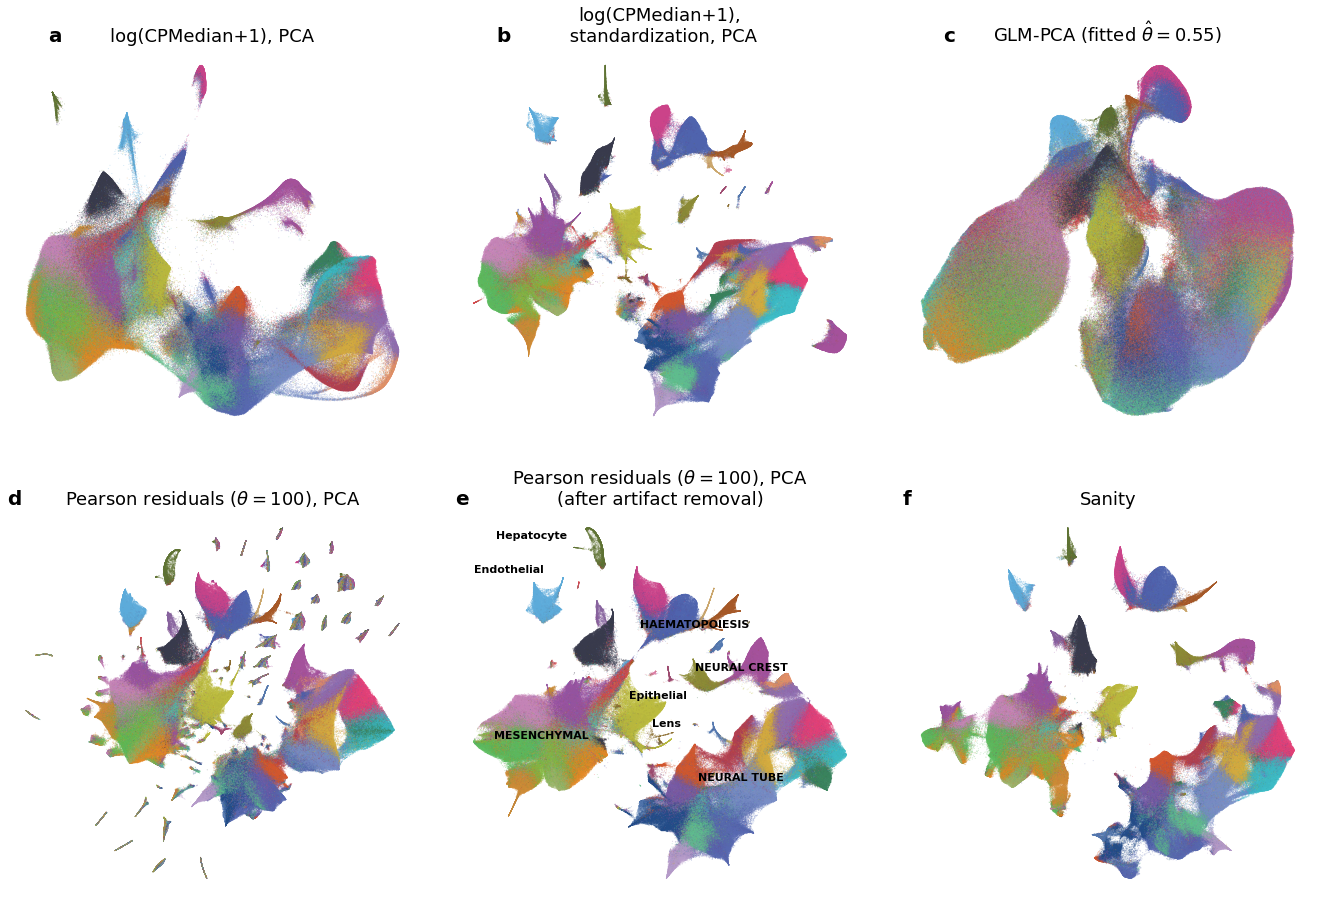

In [10]:
title_fontsize = 20
title_fontweight = "bold"

letters = ['a','b','c', 'd', 'e', 'f']

#random permutation for plotting
np.random.seed(42)
rnd_idx = np.random.permutation(sum(clusters>=0))


with sns.plotting_context('talk'):

    tsnes = [adata_hvg_pearson.obsm['pca_logmedian_tsne'],
             adata_hvg_pearson.obsm['pca_logmedian_scaled_tsne'],
             adata_hvg_pearson.obsm['glmpca_batchsize10k_tsne'],
             adata_hvg_pearson.obsm['pca_pearson_tsne'],
             adata_hvg_pearson_batchcorrected.obsm['pca_pearson_tsne'],
             adata_hvg_pearson.obsm['pca_sanity_tsne']]
    titles = ['log(CPMedian+1), PCA',
              'log(CPMedian+1),\n standardization, PCA',
              r'GLM-PCA (fitted $\hat\theta=0.55$)',
              r'Pearson residuals ($\theta=100$), PCA',
              r'Pearson residuals ($\theta=100$), PCA'+'\n(after artifact removal)',
              'Sanity']
    
    scale=1.3
    plt.figure(figsize=(18*scale,12*scale))

    ax1 = plt.subplot2grid(shape=(2,6), loc=(0, 0), colspan=2)
    ax2 = plt.subplot2grid(shape=(2,6), loc=(0, 2), colspan=2)
    ax3 = plt.subplot2grid(shape=(2,6), loc=(0, 4), colspan=2)
    ax4 = plt.subplot2grid(shape=(2,6), loc=(1, 0), colspan=2)
    ax5 = plt.subplot2grid(shape=(2,6), loc=(1, 2), colspan=2)
    ax6 = plt.subplot2grid(shape=(2,6), loc=(1, 4), colspan=2)


    axes = [ax1,ax2,ax3,ax4,ax5,ax6]
    
    for i,(ax,title,tsne,letter) in enumerate(zip(axes,titles,tsnes,letters)):
        
        ax.set_title(title)
        titleletter_loc = (0.1,1.015) if i in [0,1,2] else (0,1.015)
        ax.text(*titleletter_loc,letters[i],transform=ax.transAxes,fontsize=title_fontsize,fontweight=title_fontweight)        

        ax.scatter(*tsne[clusters>=0][rnd_idx].T,c=clusterColors[clusters[clusters>=0]][rnd_idx],s=1,edgecolor='none',alpha=0.3,rasterized=True)
        ax.axis('off')


        sns.despine()
        
        if i==4:

            for t in range(len(trajText)):
                ax.text(**trajTextCoords[t], s=trajText[t],fontsize=11,ha='center', va='center',fontweight='bold')

    plt.savefig('figures/extra/Fig4_including_sanity.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    

It is interesting to note that Sanity (Panel f) produces a clean embedding with low noise. However, it misses the batch effect that Pearson residuals uncover in Panel d, and shows some split-offs from the mesenchymal and neural tube continents that warrant further investigation.

In [13]:
%load_ext watermark

In [14]:
watermark --iversions

matplotlib: 3.3.3
pandas    : 1.2.0
numpy     : 1.20.1
anndata   : 0.7.5
scipy     : 1.6.0
seaborn   : 0.11.1



In [15]:
watermark

Last updated: 2021-07-31T18:20:14.026292+02:00

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.21.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 3.10.0-957.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

